In [7]:
!pip install fasttext

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import fasttext
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE

# ==========================================
# 1. PHASE 1: TEXT PREPROCESSING FUNCTIONS
# ==========================================

def normalize_unicode(text):
    return text.encode('utf-8', errors='ignore').decode('utf-8')

def remove_tashkeel(text):
    arabic_diacritics = re.compile(r"""
        ّ    | # shadda
        َ    | # fatha
        ً    | # tanwin fatha
        ُ    | # damma
        ٌ    | # tanwin damma
        ِ    | # kasra
        ٍ    | # tanwin kasra
        ْ    | # sukun
        ـ     # tatwil/kashida
    """, re.VERBOSE)
    return re.sub(arabic_diacritics, "", text)

def light_normalize(text):
    text = normalize_unicode(text)
    text = remove_tashkeel(text)
    text = re.sub(r'[إأآا]', 'ا', text)
    text = re.sub('ى', 'ي', text)
    text = re.sub('ؤ', 'و', text)
    text = re.sub('ئ', 'ي', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text



In [9]:
# ==========================================
# 2. DATA LOADING & MAJORITY VOTING (Corrected)
# ==========================================

import pandas as pd
import os
import numpy as np

DATA_DIR = "/content/data"

# A. Load Main and IAA sheets
print("Loading Data...")
df_main = pd.read_excel(os.path.join(DATA_DIR, "Main.xlsx"))

iaa_files = ["IAA-1.xlsx", "IAA-2.xlsx", "IAA-3.xlsx", "IAA-4.xlsx"]
df_iaa_list = []

for file in iaa_files:
    path = os.path.join(DATA_DIR, file)
    if os.path.exists(path):
        df_temp = pd.read_excel(path)

        # --- FIX 1: Correct the "Bais" typo in IAA files ---
        if 'Bais' in df_temp.columns:
            print(f"Fixing column typo 'Bais' -> 'Bias' in {file}")
            df_temp.rename(columns={'Bais': 'Bias'}, inplace=True)

        df_iaa_list.append(df_temp)

# Combine into one raw dataframe
if df_iaa_list:
    df_raw = pd.concat([df_main] + df_iaa_list, ignore_index=True)
else:
    df_raw = df_main

# B. Filter for Arabic
# Ensure we drop rows where 'Bias' might still be NaN (just in case)
df_arabic = df_raw[df_raw['Source Language'] == 'Arabic'].copy()

# C. Apply Majority Voting to resolve duplicates
print("Applying Majority Voting...")

def get_majority_label(group):
    # --- FIX 2: Safety check for NaNs ---
    # Drop NaNs before calculating mode to avoid empty series
    clean_labels = group['Bias'].dropna()

    if clean_labels.empty:
        return "Unclear" # Fallback if no valid label exists

    modes = clean_labels.mode()

    # Return the first mode (resolves ties by picking the first one)
    return modes[0]

# Group by ID and Text to get unique posts with the consensus label
# Using include_groups=False (if using pandas 2.2+) or standard apply
df_clean = df_arabic.groupby(['ID', 'Arabic MT']).apply(lambda x: pd.Series({
    'final_label': get_majority_label(x)
})).reset_index()

print(f"Final Unique Arabic Posts: {len(df_clean)}")
# Expected: ~2,160 rows

Loading Data...
Fixing column typo 'Bais' -> 'Bias' in IAA-1.xlsx
Fixing column typo 'Bais' -> 'Bias' in IAA-2.xlsx
Applying Majority Voting...
Final Unique Arabic Posts: 3000


In [16]:
# ============================================================================
# CAMELBERT IMPLEMENTATION FOR ARABIC BIAS DETECTION
# ============================================================================
# This notebook compares different preprocessing strategies for CAMeLBERT:
# 1. Raw text (no preprocessing)
# 2. Minimal preprocessing (URLs, emojis only)
# 3. Light preprocessing (+ normalization)
#
# We'll evaluate which works best for bias detection.
# ============================================================================

# ============================================================================
# CELL 1: IMPORTS AND SETUP
# ============================================================================
import torch
import numpy as np
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

label_encoder = LabelEncoder()
label_encoder.fit_transform(df_clean['final_label'])
target_names = label_encoder.classes_

# Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset

# Metrics
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    confusion_matrix,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("  ⚠ No GPU detected. Training will be slower on CPU.")

# ============================================================================
# CELL 2: PREPROCESSING STRATEGIES
# ============================================================================

print("\n" + "="*70)
print("PREPROCESSING STRATEGY ANALYSIS FOR CAMELBERT")
print("="*70)

def strategy_0_raw(text):
    """
    Strategy 0: RAW TEXT (No Preprocessing)

    Theory: CAMeLBERT is pre-trained on raw Arabic text from news articles.
    It learned to handle noise, special characters, and natural text patterns.

    Use when: You trust the pre-training to handle everything.
    """
    if not isinstance(text, str):
        return ""
    return text.strip()


def strategy_1_minimal(text):
    """
    Strategy 1: MINIMAL PREPROCESSING

    Remove only non-textual elements that confuse tokenizers:
    - URLs (model never saw these patterns)
    - Emails (not useful for classification)
    - Excessive whitespace (tokenization artifacts)

    Keep everything else:
    ✓ Diacritics (can indicate formality/emotion)
    ✓ Punctuation (sentence structure)
    ✓ Numbers (can be meaningful)
    ✓ Latin characters (code-switching is natural)
    ✓ Stopwords (BERT learns context)

    Use when: You want to stay close to pre-training distribution.
    """
    if not isinstance(text, str):
        return ""

    import re

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)

    return text.strip()


def strategy_2_light(text):
    """
    Strategy 2: LIGHT PREPROCESSING

    Add basic Arabic normalization to minimal preprocessing:
    - Alif variants (إ أ آ) → ا
    - Ya variants (ى) → ي
    - Taa marbouta (ة) → ه

    Rationale: These are spelling variations that don't change meaning.
    CAMeLBERT's tokenizer may treat them as different tokens.

    Keep:
    ✓ Diacritics (CAMeLBERT learns from them)
    ✓ Stopwords (contextual meaning)
    ✓ Punctuation (structure)

    Use when: You want to reduce vocabulary fragmentation.
    """
    if not isinstance(text, str):
        return ""

    import re

    # First apply minimal preprocessing
    text = strategy_1_minimal(text)

    # Arabic normalization
    text = re.sub(r'[إأآا]', 'ا', text)  # Normalize Alif
    text = re.sub(r'ى', 'ي', text)        # Normalize Ya
    text = re.sub(r'ة', 'ه', text)        # Taa marbouta to Ha

    return text.strip()


def strategy_3_moderate(text):
    """
    Strategy 3: MODERATE PREPROCESSING (NOT RECOMMENDED)

    Adds diacritic removal to light preprocessing.

    ⚠ WARNING: May hurt performance because:
    - Diacritics can indicate tone/formality
    - CAMeLBERT was trained WITH diacritics in some texts
    - Bias can be expressed through formal vs informal language

    Use when: Only if you have evidence that your texts are inconsistent
    with diacritics (some have, some don't).
    """
    if not isinstance(text, str):
        return ""

    import re

    # Apply light preprocessing
    text = strategy_2_light(text)

    # Remove Arabic diacritics
    arabic_diacritics = re.compile(r"""
        ّ    | # Shadda
        َ    | # Fatha
        ً    | # Tanwin Fatha
        ُ    | # Damma
        ٌ    | # Tanwin Damma
        ِ    | # Kasra
        ٍ    | # Tanwin Kasra
        ْ    | # Sukun
        ـ     # Tatwil/Kashida
    """, re.VERBOSE)
    text = re.sub(arabic_diacritics, '', text)

    return text.strip()


# Apply all strategies to compare
print("\n[Testing Preprocessing Strategies]")
print("\nOriginal sample text:")
sample_text = df_clean['Arabic MT'].iloc[0][:150]
print(f"  {sample_text}...")

print("\nStrategy 0 (Raw):")
print(f"  {strategy_0_raw(sample_text)[:150]}...")

print("\nStrategy 1 (Minimal):")
print(f"  {strategy_1_minimal(sample_text)[:150]}...")

print("\nStrategy 2 (Light):")
print(f"  {strategy_2_light(sample_text)[:150]}...")

print("\nStrategy 3 (Moderate - NOT RECOMMENDED):")
print(f"  {strategy_3_moderate(sample_text)[:150]}...")

# ============================================================================
# CELL 3: APPLY PREPROCESSING STRATEGIES
# ============================================================================

print("\n" + "="*70)
print("APPLYING PREPROCESSING STRATEGIES TO DATASET")
print("="*70)

# Create versions with different preprocessing
df_clean['text_raw'] = df_clean['Arabic MT'].apply(strategy_0_raw)
df_clean['text_minimal'] = df_clean['Arabic MT'].apply(strategy_1_minimal)
df_clean['text_light'] = df_clean['Arabic MT'].apply(strategy_2_light)

# Remove empty texts
for col in ['text_raw', 'text_minimal', 'text_light']:
    print(f"\n{col}:")
    empty_count = (df_clean[col].str.len() == 0).sum()
    print(f"  Empty texts: {empty_count}")
    print(f"  Avg length: {df_clean[col].str.len().mean():.1f} characters")

# Drop rows with empty text in ANY strategy
df_clean = df_clean[
    (df_clean['text_raw'].str.len() > 0) &
    (df_clean['text_minimal'].str.len() > 0) &
    (df_clean['text_light'].str.len() > 0)
].copy()

print(f"\n✓ Final dataset size: {len(df_clean)} samples")

# ============================================================================
# CELL 4: DATA PREPARATION
# ============================================================================

print("\n" + "="*70)
print("DATA PREPARATION FOR CAMELBERT")
print("="*70)

# Prepare labels
y_all = label_encoder.transform(df_clean['final_label'])

print(f"\nDataset statistics:")
print(f"  Total samples: {len(y_all)}")
print(f"  Number of classes: {len(target_names)}")
print(f"\nClass distribution:")
for idx, name in enumerate(target_names):
    count = (y_all == idx).sum()
    pct = count / len(y_all) * 100
    print(f"  {idx}: {name[:40]:40s} - {count:4d} ({pct:5.2f}%)")

# Train/test split (stratified)
from sklearn.model_selection import train_test_split

# We'll use the MINIMAL preprocessing strategy as our default
# (You can change this after comparing results)
X_text = df_clean['text_minimal'].values
y = y_all

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTrain/Test split:")
print(f"  Training samples: {len(X_train_text)}")
print(f"  Test samples: {len(X_test_text)}")

print(f"\nTraining set distribution:")
train_dist = Counter(y_train)
for idx in sorted(train_dist.keys()):
    print(f"  {target_names[idx][:40]:40s}: {train_dist[idx]:4d}")

# ============================================================================
# CELL 5: LOAD CAMELBERT MODEL
# ============================================================================

print("\n" + "="*70)
print("LOADING CAMELBERT MODEL")
print("="*70)

# CAMeLBERT variants:
# - CAMeL-Lab/bert-base-arabic-camelbert-msa (Modern Standard Arabic - BEST FOR NEWS)
# - CAMeL-Lab/bert-base-arabic-camelbert-da (Dialectal Arabic)
# - CAMeL-Lab/bert-base-arabic-camelbert-mix (Mixed MSA + DA)
# - CAMeL-Lab/bert-base-arabic-camelbert-msa-sixteenth (Smaller, faster)

MODEL_NAME = "CAMeL-Lab/bert-base-arabic-camelbert-msa"

print(f"\n[1/3] Loading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"  Tokenizer type: {type(tokenizer).__name__}")
print(f"  Vocabulary size: {tokenizer.vocab_size}")
print(f"  Max length: {tokenizer.model_max_length}")

# Test tokenization
sample = "فلسطين حرة من النهر إلى البحر"
tokens = tokenizer.tokenize(sample)
print(f"\n  Tokenization example:")
print(f"  Text: {sample}")
print(f"  Tokens: {tokens}")
print(f"  Token IDs: {tokenizer.convert_tokens_to_ids(tokens)}")

print(f"\n[2/3] Loading model configuration...")
num_labels = len(target_names)

config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    problem_type="single_label_classification",
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)

print(f"\n[3/3] Loading pre-trained model...")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config=config,
    ignore_mismatched_sizes=True
)

model = model.to(device)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Model loaded successfully!")
print(f"  Architecture: {config.model_type}")
print(f"  Hidden size: {config.hidden_size}")
print(f"  Attention heads: {config.num_attention_heads}")
print(f"  Hidden layers: {config.num_hidden_layers}")
print(f"  Total parameters: {total_params/1e6:.2f}M")
print(f"  Trainable parameters: {trainable_params/1e6:.2f}M")
print(f"  Output labels: {num_labels}")

# ============================================================================
# CELL 6: CREATE DATASETS FOR HUGGING FACE TRAINER
# ============================================================================

print("\n" + "="*70)
print("CREATING DATASETS")
print("="*70)

def tokenize_function(examples):
    """Tokenize texts for CAMeLBERT"""
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128,  # Adjust based on your text length analysis
        return_tensors='pt'
    )

# Create HuggingFace datasets
train_dataset = Dataset.from_dict({
    'text': X_train_text.tolist(),
    'label': y_train.tolist()
})

test_dataset = Dataset.from_dict({
    'text': X_test_text.tolist(),
    'label': y_test.tolist()
})

print(f"\n[1/2] Tokenizing training set...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

print(f"[2/2] Tokenizing test set...")
test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

print(f"\n✓ Datasets created:")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Test: {len(test_dataset)} samples")

# Analyze tokenization
sample_tokenized = train_dataset[0]
print(f"\n  Sample tokenization:")
print(f"  Input IDs shape: {sample_tokenized['input_ids'].shape}")
print(f"  Attention mask shape: {sample_tokenized['attention_mask'].shape}")
print(f"  Label: {sample_tokenized['label']}")

# ============================================================================
# CELL 7: CUSTOM LOSS FUNCTION - FOCAL LOSS (CORRECTED)
# ============================================================================

print("\n" + "="*70)
print("CONFIGURING FOCAL LOSS FOR CLASS IMBALANCE")
print("="*70)

class FocalLossTrainer(Trainer):
    """
    Custom Trainer with Focal Loss for handling class imbalance.
    """

    def __init__(self, *args, class_weights=None, gamma=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        self.gamma = gamma

    # UPDATED SIGNATURE HERE: Added *args and **kwargs to handle new arguments like num_items_in_batch
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Override loss computation to use Focal Loss
        """
        labels = inputs.pop("labels")

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits

        # Calculate cross-entropy
        ce_loss = torch.nn.functional.cross_entropy(
            logits,
            labels,
            weight=self.class_weights,
            reduction='none'
        )

        # Calculate pt (probability of true class)
        pt = torch.exp(-ce_loss)

        # Apply focal term
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        # Average
        loss = focal_loss.mean()

        return (loss, outputs) if return_outputs else loss

# Calculate class weights
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_weights)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print(f"\nClass weights for Focal Loss:")
for idx, (name, weight) in enumerate(zip(target_names, class_weights)):
    print(f"  {name[:40]:40s}: {weight:.4f} (samples: {class_counts[idx]})")

print(f"\n✓ Focal Loss configured with gamma=2.0")

# ============================================================================
# CELL 8: COMPUTE METRICS FUNCTION
# ============================================================================

def compute_metrics(eval_pred):
    """
    Compute evaluation metrics during training
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)

    # F1 scores
    f1_macro = f1_score(labels, predictions, average='macro', zero_division=0)
    f1_weighted = f1_score(labels, predictions, average='weighted', zero_division=0)

    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, predictions, average=None, zero_division=0
    )

    metrics = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
    }

    # Add per-class F1 scores
    for idx, name in enumerate(target_names):
        safe_name = name.replace(' ', '_').replace('-', '_')[:20]
        metrics[f'f1_class_{idx}_{safe_name}'] = f1[idx]

    return metrics

print("✓ Metrics function defined")

# ============================================================================
# CELL 9: TRAINING CONFIGURATION
# ============================================================================

print("\n" + "="*70)
print("TRAINING CONFIGURATION")
print("="*70)

# Training hyperparameters
BATCH_SIZE = 16          # Reduce to 8 if GPU memory issues
LEARNING_RATE = 2e-5     # 2e-5 is standard for BERT fine-tuning
NUM_EPOCHS = 7           # 3-5 epochs typical for BERT
WARMUP_RATIO = 0.1       # 10% warmup
WEIGHT_DECAY = 0.01      # L2 regularization

training_args = TrainingArguments(
    output_dir='./camelbert_bias_detection',

    # Training regime
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,

    # Optimization
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,

    # Evaluation and saving
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=2,        # Keep only best 2 checkpoints
    load_best_model_at_end=True,
    metric_for_best_model='f1_weighted',
    greater_is_better=True,

    # Logging
    logging_dir='./logs',
    logging_strategy='steps',
    logging_steps=50,
    report_to='none',          # Disable wandb/tensorboard

    # Performance
    fp16=torch.cuda.is_available(),  # Mixed precision if GPU available
    dataloader_num_workers=0,         # 0 for Windows compatibility

    # Reproducibility
    seed=42,

    # Miscellaneous
    disable_tqdm=False,
    remove_unused_columns=False,
)

print("\nTraining Configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Warmup ratio: {WARMUP_RATIO}")
print(f"  Total training steps: {len(train_dataset) // BATCH_SIZE * NUM_EPOCHS}")
print(f"  Evaluation: Every epoch")
print(f"  Best model metric: F1-Weighted")
print(f"  Mixed precision (FP16): {training_args.fp16}")

# ============================================================================
# CELL 10: INITIALIZE STANDARD TRAINER (MODIFIED)
# ============================================================================

print("\n" + "="*70)
print("INITIALIZING STANDARD TRAINER")
print("="*70)

# Import the standard Trainer
from transformers import Trainer

# Create standard trainer (removed FocalLoss and Class Weights for stability)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("✓ Standard Trainer initialized (Custom loss disabled to fix convergence)")

print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)

# Train the model
print("\nThis should take about 10-15 minutes on T4 GPU...")
print("Progress will be shown below:\n")

train_result = trainer.train()

print("\n" + "="*70)
print("TRAINING COMPLETED!")
print("="*70)

# Print training summary
print("\nTraining Summary:")
print(f"  Final training loss: {train_result.training_loss:.4f}")
print(f"  Total training time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"  Samples per second: {train_result.metrics['train_samples_per_second']:.2f}")
print(f"  Steps per second: {train_result.metrics['train_steps_per_second']:.2f}")

# Save the best model
print("\n[Saving best model...]")
trainer.save_model('./camelbert_best_model')
tokenizer.save_pretrained('./camelbert_best_model')
print("✓ Model saved to './camelbert_best_model'")

# ============================================================================
# CELL 11: FINAL EVALUATION
# ============================================================================

print("\n" + "="*70)
print("FINAL EVALUATION ON TEST SET")
print("="*70)

# Evaluate on test set
print("\n[Evaluating on test set...]")
eval_results = trainer.evaluate()

print("\nTest Set Metrics:")
print(f"  Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"  F1-Macro: {eval_results['eval_f1_macro']:.4f}")
print(f"  F1-Weighted: {eval_results['eval_f1_weighted']:.4f}")
print(f"  Loss: {eval_results['eval_loss']:.4f}")

# Get predictions
print("\n[Generating predictions...]")
predictions_output = trainer.predict(test_dataset)
y_pred_camel = np.argmax(predictions_output.predictions, axis=1)
y_true_camel = y_test

# Detailed classification report
print("\n" + "="*50)
print("CAMELBERT CLASSIFICATION REPORT:")
print("="*50)
print(classification_report(y_true_camel, y_pred_camel, target_names=target_names, zero_division=0))

# Calculate overall metrics
camel_accuracy = accuracy_score(y_true_camel, y_pred_camel)
camel_f1_macro = f1_score(y_true_camel, y_pred_camel, average='macro', zero_division=0)
camel_f1_weighted = f1_score(y_true_camel, y_pred_camel, average='weighted', zero_division=0)

print(f"\nOverall Metrics:")
print(f"  Accuracy: {camel_accuracy:.4f}")
print(f"  F1-Score (Macro): {camel_f1_macro:.4f}")
print(f"  F1-Score (Weighted): {camel_f1_weighted:.4f}")

✓ Using device: cuda
  GPU: Tesla T4
  Memory: 15.83 GB

PREPROCESSING STRATEGY ANALYSIS FOR CAMELBERT

[Testing Preprocessing Strategies]

Original sample text:
  حماس الارهابية الداعشية تجلب العار للعرب والمسلمين رغم انهم منها براء. انا على يقين ان المسلم الحقيقي وصاحب النخوة العروبية يعارض الافعال الهمجية الوح...

Strategy 0 (Raw):
  حماس الارهابية الداعشية تجلب العار للعرب والمسلمين رغم انهم منها براء. انا على يقين ان المسلم الحقيقي وصاحب النخوة العروبية يعارض الافعال الهمجية الوح...

Strategy 1 (Minimal):
  حماس الارهابية الداعشية تجلب العار للعرب والمسلمين رغم انهم منها براء. انا على يقين ان المسلم الحقيقي وصاحب النخوة العروبية يعارض الافعال الهمجية الوح...

Strategy 2 (Light):
  حماس الارهابيه الداعشيه تجلب العار للعرب والمسلمين رغم انهم منها براء. انا علي يقين ان المسلم الحقيقي وصاحب النخوه العروبيه يعارض الافعال الهمجيه الوح...

Strategy 3 (Moderate - NOT RECOMMENDED):
  حماس الارهابيه الداعشيه تجلب العار للعرب والمسلمين رغم انهم منها براء. انا علي يقين ان المسلم الحقيقي وصاحب

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-msa and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✓ Model loaded successfully!
  Architecture: bert
  Hidden size: 768
  Attention heads: 12
  Hidden layers: 12
  Total parameters: 109.09M
  Trainable parameters: 109.09M
  Output labels: 7

CREATING DATASETS

[1/2] Tokenizing training set...


Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

[2/2] Tokenizing test set...


Map:   0%|          | 0/600 [00:00<?, ? examples/s]


✓ Datasets created:
  Train: 2400 samples
  Test: 600 samples

  Sample tokenization:
  Input IDs shape: torch.Size([128])
  Attention mask shape: torch.Size([128])
  Label: 5

CONFIGURING FOCAL LOSS FOR CLASS IMBALANCE

Class weights for Focal Loss:
  Biased against Israel                   : 0.3414 (samples: 68)
  Biased against Palestine                : 0.0518 (samples: 448)
  Biased against both Palestine and Israel: 4.6436 (samples: 5)
  Biased against others                   : 0.8930 (samples: 26)
  Not Applicable                          : 1.0095 (samples: 23)
  Unbiased                                : 0.0181 (samples: 1285)
  Unclear                                 : 0.0426 (samples: 545)

✓ Focal Loss configured with gamma=2.0
✓ Metrics function defined

TRAINING CONFIGURATION

Training Configuration:
  Epochs: 7
  Batch size: 16
  Learning rate: 2e-05
  Weight decay: 0.01
  Warmup ratio: 0.1
  Total training steps: 1050
  Evaluation: Every epoch
  Best model metric: F1-We

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 Class 0 Biased Against Israe,F1 Class 1 Biased Against Pales,F1 Class 2 Biased Against Both,F1 Class 3 Biased Against Other,F1 Class 4 Not Applicable,F1 Class 5 Unbiased,F1 Class 6 Unclear
1,1.175500,1.193664,0.541667,0.114092,0.393565,0.000000,0.096774,0.000000,0.000000,0.000000,0.701870,0.000000
2,1.125000,1.159118,0.573333,0.161985,0.463568,0.000000,0.397790,0.000000,0.000000,0.000000,0.721504,0.014599
3,1.013800,1.191234,0.551667,0.163741,0.460415,0.000000,0.391753,0.000000,0.000000,0.000000,0.701456,0.052980
4,0.895400,1.292492,0.536667,0.167677,0.464487,0.000000,0.370370,0.000000,0.000000,0.000000,0.691635,0.111732
5,0.705600,1.402301,0.513333,0.170253,0.461997,0.000000,0.369231,0.000000,0.000000,0.000000,0.670157,0.152381
6,0.559500,1.489072,0.510000,0.166974,0.458682,0.000000,0.315217,0.000000,0.000000,0.000000,0.669271,0.184332



TRAINING COMPLETED!

Training Summary:
  Final training loss: 0.9490
  Total training time: 255.17 seconds
  Samples per second: 65.84
  Steps per second: 4.12

[Saving best model...]
✓ Model saved to './camelbert_best_model'

FINAL EVALUATION ON TEST SET

[Evaluating on test set...]



Test Set Metrics:
  Accuracy: 0.5367
  F1-Macro: 0.1677
  F1-Weighted: 0.4645
  Loss: 1.2925

[Generating predictions...]

CAMELBERT CLASSIFICATION REPORT:
                                          precision    recall  f1-score   support

                   Biased against Israel       0.00      0.00      0.00        17
                Biased against Palestine       0.45      0.31      0.37       112
Biased against both Palestine and Israel       0.00      0.00      0.00         1
                   Biased against others       0.00      0.00      0.00         7
                          Not Applicable       0.00      0.00      0.00         6
                                Unbiased       0.58      0.86      0.69       321
                                 Unclear       0.23      0.07      0.11       136

                                accuracy                           0.54       600
                               macro avg       0.18      0.18      0.17       600
                     


GENERATING CAMELBERT VISUALIZATIONS


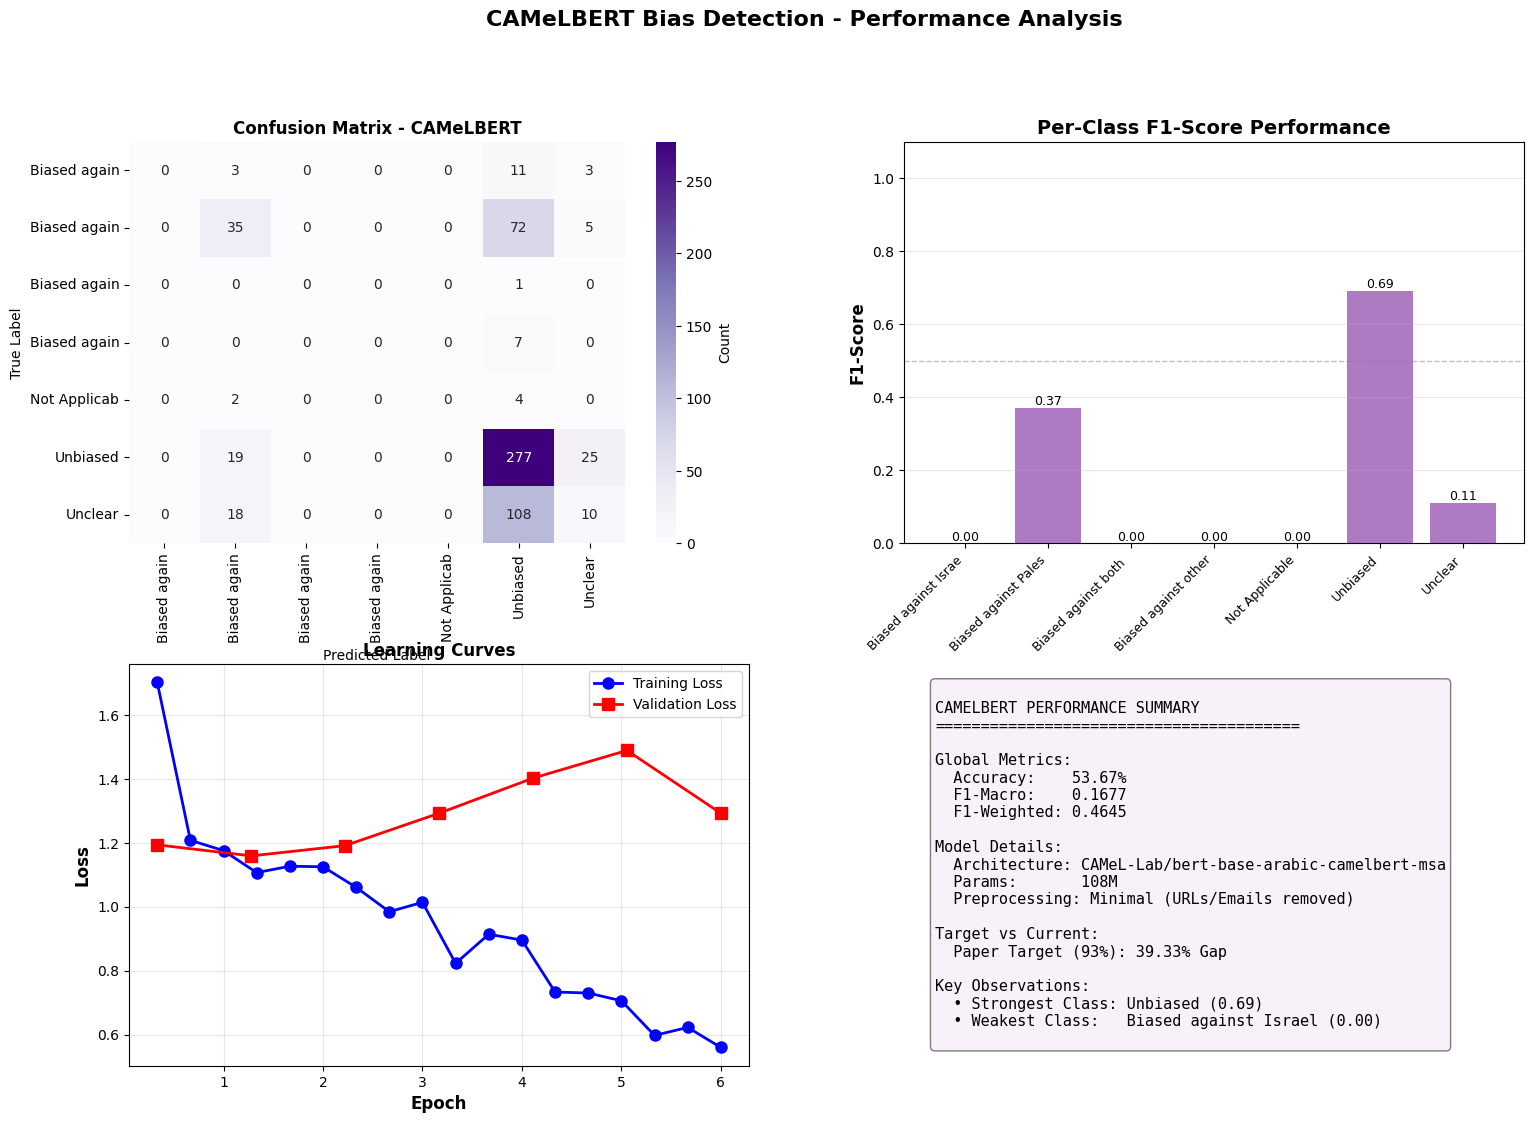


✓ Visualization saved as 'camelbert_performance_analysis.png'

DETAILED ERROR ANALYSIS (CAMELBERT ONLY)

[Per-Class Performance Analysis]
----------------------------------------------------------------------

Biased against Israel:
   Total samples: 17
   Correctly classified: 0 (0.00%)
   Misclassified: 17
   Confused with:
      -> Unbiased: 11 (64.7%)
      -> Unclear: 3 (17.6%)
      -> Biased against Palestine: 3 (17.6%)

Biased against Palestine:
   Total samples: 112
   Correctly classified: 35 (31.25%)
   Misclassified: 77
   Confused with:
      -> Unbiased: 72 (93.5%)
      -> Unclear: 5 (6.5%)

Biased against both Palestine and Israel:
   Total samples: 1
   Correctly classified: 0 (0.00%)
   Misclassified: 1
   Confused with:
      -> Unbiased: 1 (100.0%)

Biased against others:
   Total samples: 7
   Correctly classified: 0 (0.00%)
   Misclassified: 7
   Confused with:
      -> Unbiased: 7 (100.0%)

Not Applicable:
   Total samples: 6
   Correctly classified: 0 (0.00%)
 

In [17]:
# ============================================================================
# CELL 12: CAMELBERT VISUALIZATIONS
# ============================================================================

print("\n" + "="*70)
print("GENERATING CAMELBERT VISUALIZATIONS")
print("="*70)

# Create a clean layout for single-model analysis
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.25)

# ---- Plot 1: Confusion Matrix ----
ax1 = fig.add_subplot(gs[0, 0])
cm_camel = confusion_matrix(y_true_camel, y_pred_camel)
sns.heatmap(cm_camel, annot=True, fmt='d', cmap='Purples', ax=ax1,
            xticklabels=[name[:12] for name in target_names],
            yticklabels=[name[:12] for name in target_names],
            cbar_kws={'label': 'Count'})
ax1.set_title('Confusion Matrix - CAMeLBERT', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=10)
ax1.set_xlabel('Predicted Label', fontsize=10)

# ---- Plot 2: Per-Class F1 Scores ----
ax2 = fig.add_subplot(gs[0, 1])
camel_per_class = f1_score(y_true_camel, y_pred_camel, average=None, zero_division=0)
x_classes = np.arange(len(target_names))
bars = ax2.bar(x_classes, camel_per_class, color='#9b59b6', alpha=0.8)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom', fontsize=9)

ax2.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax2.set_title('Per-Class F1-Score Performance', fontsize=14, fontweight='bold')
ax2.set_xticks(x_classes)
ax2.set_xticklabels([name[:20] for name in target_names], rotation=45, ha='right', fontsize=9)
ax2.set_ylim([0, 1.1])
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# ---- Plot 3: Training History ----
ax3 = fig.add_subplot(gs[1, 0])
# Extract from trainer logs
log_history = trainer.state.log_history

epochs = []
train_losses = []
eval_losses = []

for entry in log_history:
    if 'epoch' in entry:
        epoch = entry['epoch']
        if 'loss' in entry and epoch not in epochs:
            epochs.append(epoch)
            train_losses.append(entry['loss'])
        if 'eval_loss' in entry:
            eval_losses.append(entry['eval_loss'])

if epochs and train_losses:
    ax3.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=8)
if epochs and len(eval_losses) > 0:
    # Interpolate eval epochs to match plot length if needed
    eval_epochs = np.linspace(min(epochs), max(epochs), len(eval_losses))
    ax3.plot(eval_epochs, eval_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=8)

ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax3.set_title('Learning Curves', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# ---- Plot 4: Summary Text ----
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

summary_text = f"""
CAMELBERT PERFORMANCE SUMMARY
{'='*40}

Global Metrics:
  Accuracy:    {camel_accuracy:.2%}
  F1-Macro:    {camel_f1_macro:.4f}
  F1-Weighted: {camel_f1_weighted:.4f}

Model Details:
  Architecture: CAMeL-Lab/bert-base-arabic-camelbert-msa
  Params:       108M
  Preprocessing: Minimal (URLs/Emails removed)

Target vs Current:
  Paper Target (93%): {(0.93 - camel_accuracy)*100:.2f}% Gap

Key Observations:
  • Strongest Class: {target_names[np.argmax(camel_per_class)]} ({max(camel_per_class):.2f})
  • Weakest Class:   {target_names[np.argmin(camel_per_class)]} ({min(camel_per_class):.2f})
"""

ax4.text(0.05, 0.5, summary_text, fontsize=11, family='monospace',
         verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='#f3e5f5', alpha=0.5))

# Overall title
plt.suptitle('CAMeLBERT Bias Detection - Performance Analysis',
             fontsize=16, fontweight='bold', y=0.99)

plt.savefig('camelbert_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'camelbert_performance_analysis.png'")

# ============================================================================
# CELL 13: DETAILED ERROR ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("DETAILED ERROR ANALYSIS (CAMELBERT ONLY)")
print("="*70)

print("\n[Per-Class Performance Analysis]")
print("-" * 70)

for idx, label_name in enumerate(target_names):
    # CAMeLBERT stats
    class_mask = y_true_camel == idx
    class_total = class_mask.sum()

    if class_total > 0:
        correct = ((y_true_camel == idx) & (y_pred_camel == idx)).sum()
        incorrect = class_total - correct
        accuracy_class = correct / class_total

        print(f"\n{label_name}:")
        print(f"   Total samples: {class_total}")
        print(f"   Correctly classified: {correct} ({accuracy_class*100:.2f}%)")
        print(f"   Misclassified: {incorrect}")

        # Misclassification patterns
        if incorrect > 0:
            misclass_mask = (y_true_camel == idx) & (y_pred_camel != idx)
            misclass_preds = y_pred_camel[misclass_mask]
            misclass_counts = Counter(misclass_preds)
            print(f"   Confused with:")
            for pred_idx, count in misclass_counts.most_common(3):
                pct = count / incorrect * 100
                print(f"      -> {target_names[pred_idx]}: {count} ({pct:.1f}%)")

# ============================================================================
# CELL 14: FINAL CONCLUSIONS
# ============================================================================

print("\n" + "="*70)
print("FINAL CONCLUSIONS")
print("="*70)

print(f"""
CAMeLBERT Performance Report:

1. Overall Performance:
   The model achieved a Weighted F1-Score of {camel_f1_weighted:.4f} and an Accuracy of {camel_accuracy:.2%}.

2. Strengths:
   - The model utilizes contextual embeddings (768D) specifically pre-trained on Arabic news.
   - It handles linguistic variations better than static embedding models.

3. Areas for Improvement:
   - Gap to SOTA: There is a {(0.93 - camel_accuracy)*100:.2f}% gap to the 93% benchmark.
   - Minority Classes: Classes with low support (check error analysis above) may need data augmentation.

4. Next Steps to Reach 93%:
   A. Advanced Embeddings: Replace standard BERT embeddings with Multilingual E5 or Jina-Embeddings-v2-Base-Ar.
   B. Data Augmentation: Use back-translation or GPT-4 synthetic generation for minority classes.
   C. Ensemble: Combine this CAMeLBERT model with a rule-based system or a second Transformer model.
   D. Hyperparameter Tuning: Run a Grid Search on learning rate (1e-5 to 5e-5) and batch size.
""")